In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from matplotlib import rcParams,font_manager
import os
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import pickle
from fourinarowfunctions import *

%load_ext autoreload
%autoreload 2

In [2]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 

In [3]:
direc = 'G:/My Drive/Bas Games/Analysis/'
fig_direc = 'G:/My Drive/Bas Games/Figures/'
peak_direc = 'C:/Users/svo/Documents/FourinarowData/Data/peak/'

In [4]:
def plot_with_errorbars(fig,ax,x,A,colors=None):
    m = np.nanmean(A,axis=0)
    s = np.nanstd(A-m[None,:],axis=0)/np.sqrt(A.shape[0])
    plt.errorbar(x,m,yerr = s,color='black')
    if not colors is None:
        ax.scatter(x,m,color=colors)
    else:
        ax.plot(x,m,'.')

In [5]:
#time_colors = ['#9B1A30','#F85D5F','#FFAC9A']
#learn_colors = ['#4B8F7C', '#3C7864', '#2E614D','#1F4935','#10321D']
#peak_colors = ['#00B4D8','#0096C7','#0077B6','#023E8A','#03045E']

time_colors = ['#9F4AB0','#6E207D','#430F4D']
learn_colors = ['#7DE3AC', '#0EE676', '#129951','#17452D','#20382B']
peak_colors = ['#D7E8FA','#A3CDF7','#3C92E8','#0E5296','#0F3153']

In [6]:
import pandas as pd
boards_hvh = pd.read_csv(direc+'Opt/opt_hvh.txt',delim_whitespace=True,header=None)[[0,1]].values

In [7]:
def load_params_file(filename):
    if os.path.exists(filename):
        return np.loadtxt(filename,delimiter=',')
    else:
        return np.full(shape=[10,],fill_value=np.nan)

def get_peak_user_id(i):
    df = pd.read_csv(peak_direc + 'splits/' + str(i+1) + '/data.csv',delim_whitespace=True,header=None)
    names = pd.unique(df[6])
    assert len(names)==1
    name = names[0]
    return name[:10] + '_block' + name[10:]
    #selected_peak_users = np.unique([player[:player.find('_')] for player in rating_dict.keys() if '_block' in player])

def get_peak_rt(i):
    df = pd.read_csv(peak_direc + 'splits/' + str(i+1) + '/data.csv',delim_whitespace=True,header=None)
    return df[df[4]<10][4].mean()#this is the upper limit, any rts over 10 are data errors
    #selected_peak_users = np.unique([player[:player.find('_')] for player in rating_dict.keys() if '_block' in player])    

In [8]:
def get_name(i):
    df = pd.read_csv(data_direc + 'splits/' + str(i+1) + '/data.csv',delim_whitespace=True,header=None)
    return df[6][0]#this is the upper limit, any rts over 10 are data errors
    #selected_peak_users = np.unique([player[:player.find('_')] for player in rating_dict.keys() if '_block' in player])    

In [9]:
import json
with open(direc + 'Ratings/ratings_all_expts_peak.txt') as f:
    rating_dict = json.load(f)

ratings_learn = np.array([[rating_dict['subj' + str(j).zfill(2) + 'sess' + str(i).zfill(2)] for i in range(5)] for j in range(30)])
ratings_time = np.array([[rating_dict['subj' + str(j).zfill(2) + 'cond' + str(i).zfill(2)] for i in range(3)] for j in range(30)])


In [10]:
condition_dict = {'20220630_dn': 'random',
 '20220630_hz': '[0, 2, 1]',
 '20220701_ot': '[0, 1, 2]',
 '20220701_yl': '[1, 0, 2]',
 '20220701_xl': '[0, 1, 2]',
 '20220701_ar': 'random',
 '20220701_hl': '[2, 1, 0]',
 '20220705_tl': '[0, 2, 1]',
 '20220705_ar2': 'random',
 '20220705_ao': '[0, 1, 2]',
 '20220705_cm': 'random',
 '20220706_kt': 'random',
 '20220706_cb': 'random',
 '20220706_kg': '[0, 1, 2]',
 '20220706_ll': 'random',
 '20220706_nl': '[2, 0, 1]',
 '20220706_bg': 'random',
 '20220706_hr': '[0, 2, 1]',
 '20220706_bh': '[1, 0, 2]',
 '20220706_rl': 'random',
 '20220707_wjk': 'random',
 '20220707_vb': 'random',
 '20220707_sw': '[1, 2, 0]',
 '20220707_il': '[2, 1, 0]',
 '20220707_mm': '[0, 2, 1]',
 '20220707_jn': 'random',
 '20220708_pp': '[2, 0, 1]',
 '20220708_sc': '[1, 2, 0]',
 '20220708_lp': 'random',
 '20220708_jk': '[2, 0, 1]',
 '20220711_gl': 'random',
 '20220711_kc': '[1, 2, 0]',
 '20220711_re': 'random',
 '20220711_pb': 'random',
 '20220711_ch': 'random',
 '20220712_va': 'random',
 '20220712_ms': 'random',
 '20220712_yd': '[0, 2, 1]',
 '20220712_ss': 'random',
 '20220712_ih': '[2, 0, 1]',
 '20220712_km': 'random',
 '20220712_km2': 'random',
 '20220713_aq': 'random',
 '20220713_st': 'random',
 '20220714_jf': '[2, 1, 0]',
 '20220714_sh': '[1, 2, 0]',
 '20220714_zm': 'random',
 '20220714_cm': '[2, 1, 0]',
 '20220715_ab': '[0, 1, 2]',
 '20220715_mo': 'random',
 '20220715_yf': '[1, 0, 2]',
 '20220715_zz': 'random',
 '20220718_aw': 'random',
 '20220718_yz': 'random',
 '20220718_aj': '[2, 0, 1]',
 '20220720_ae': '[1, 0, 2]',
 '20220720_cc': '[1, 0, 2]',
 '20220720_mm': 'random',
 '20220721_ag': '[1, 2, 0]',
 '20220722_rz': 'random'}

In [11]:
data_direc = 'C:/Users/svo/Documents/FourinarowData/Data/timepressure_rep/'

time_rep_names = [get_name(i) for i in range(0,180,3)]
ratings_time_rep = np.array([[rating_dict[name + '_' + str(timelimit)] for timelimit in [5000,10000,20000]] for name in time_rep_names])
params_time_rep = np.reshape(np.array([[expand_params(load_params_file(data_direc + 'splits/' + str(i) + '/params' + str(g) + '.csv')) 
                                             for g in range(1,6)] for i in range(1,181)]),[-1,3,5,58])
feature_drop_time_rep = params_time_rep[:,:,:,-1]
heuristic_quality_time_rep = np.apply_along_axis(get_heuristic_quality,arr=params_time_rep,axis=3)

In [12]:
condition = np.array([condition_dict[name] for name in time_rep_names])

In [13]:
#d = np.array([[get_depth(i,g) for g in range(1,6)] for i in range(180)])
#plt.plot(d.flatten(),np.log(np.vstack([[expand_params(load_params_file(data_direc + 'splits/' + str(i) + '/params' + str(g) + '.csv'))[2] 
#                                             for g in range(1,6)] for i in range(1,181)])).flatten(),'.')

In [14]:
np.savetxt(data_direc + 'params_time_rep.txt',
           np.vstack([[expand_params(load_params_file(data_direc + 'splits/' + str(i) + '/params' + str(g) + '.csv')) 
                                             for g in range(1,6)] for i in range(1,181)])
          )

In [15]:
def get_depth(i,g):
    filename = data_direc + 'depth/depth_timepressure_' + str(i) + '_' + str(g) + '.txt'
    if not os.path.exists(filename) or os.path.getsize(filename)==0:
        return np.nan
    else:
        return np.loadtxt(filename)

In [16]:
d = np.array([[get_depth(i,g) for g in range(1,6)] for i in range(180)])
depth_time_rep = np.reshape(d,[-1,3,5])

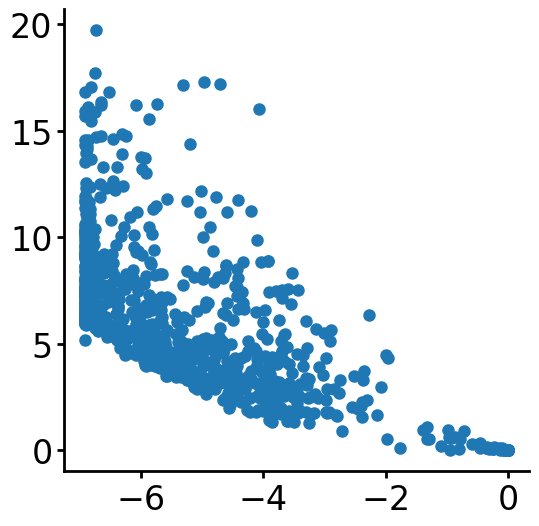

In [17]:
plt.plot(np.log(params_time_rep[:,:,:,2]).flatten(),depth_time_rep.flatten(),'.')

In [18]:
#plt.plot(ratings_time_rep.flatten(),heuristic_quality_time_rep.flatten(),'.')

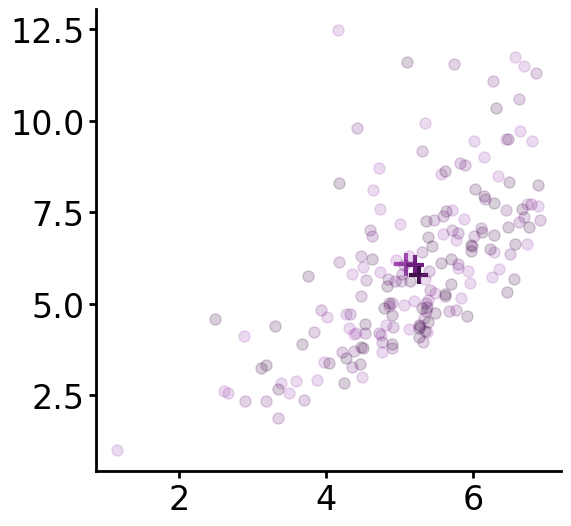

In [19]:
for i in range(3):
    x = -np.nanmean(np.log(params_time_rep[:,:,:,2]),axis=2)[:,i]
    y = np.nanmean(depth_time_rep,axis=2)[:,i]
    z = np.nanmean(params_time_rep[:,:,:,1],axis=2)[:,i]
    plt.plot(x,y,'.',color=time_colors[i],alpha=0.2)
    plt.errorbar(x=np.mean(x),y=np.mean(y),xerr=np.std(x)/np.sqrt(60),yerr=np.std(y)/np.sqrt(60),color=time_colors[i])

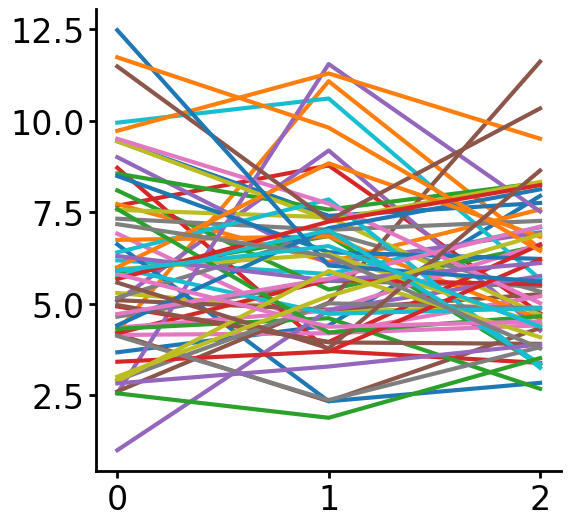

In [20]:
plt.plot(np.mean(depth_time_rep,axis=2).T)
plt.show()

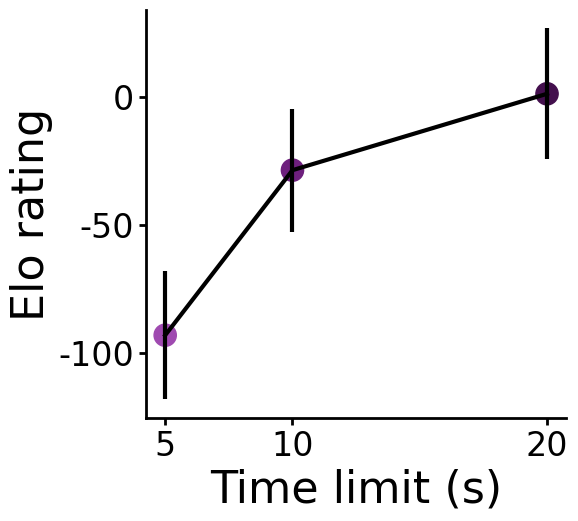

In [21]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,[5,10,20],ratings_time_rep,colors=time_colors)

#plot_with_errorbars(fig,ax,[5,10,20],ratings_time_rep[condition=='random'],colors=time_colors)
#plot_with_errorbars(fig,ax,[5,10,20],ratings_time_rep[condition!='random'],colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Elo rating')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3f.pdf')
plt.show()

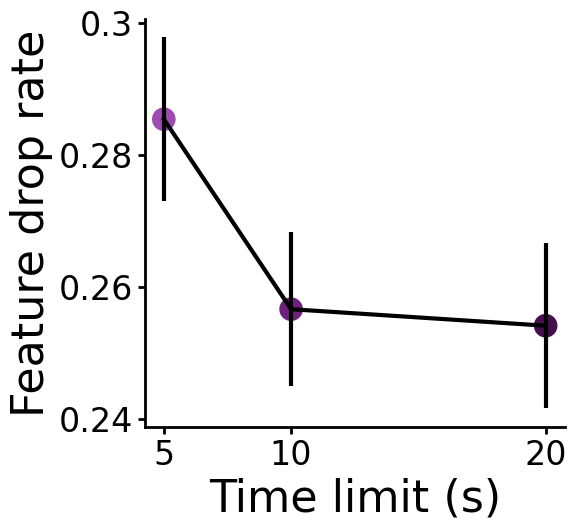

In [22]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plot_with_errorbars(fig,ax,[5,10,20],np.mean(feature_drop_time_rep,axis=2),colors=time_colors)

#plot_with_errorbars(fig,ax,[5,10,20],np.mean(feature_drop_time_rep,axis=2)[condition=='random'],colors=time_colors)
#plot_with_errorbars(fig,ax,[5,10,20],np.mean(feature_drop_time_rep,axis=2)[condition!='random'],colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Feature drop rate')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3f.pdf')
plt.show()

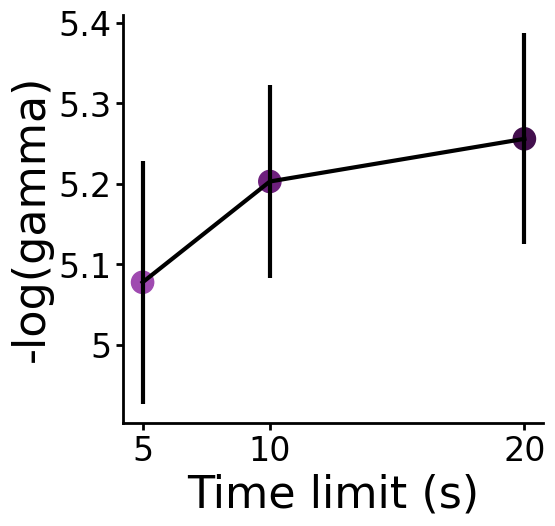

In [23]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
 
plot_with_errorbars(fig,ax,[5,10,20],-np.nanmean(np.log(params_time_rep[:,:,:,2]),axis=2),colors=time_colors)
#plot_with_errorbars(fig,ax,[5,10,20],np.nanmean(depth_time_rep,axis=2)[condition!='random'],colors=time_colors)
#plot_with_errorbars(fig,ax,[5,10,20],np.nanmean(depth_time_rep,axis=2)[condition=='random'],colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('-log(gamma)')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3f.pdf')
plt.show()

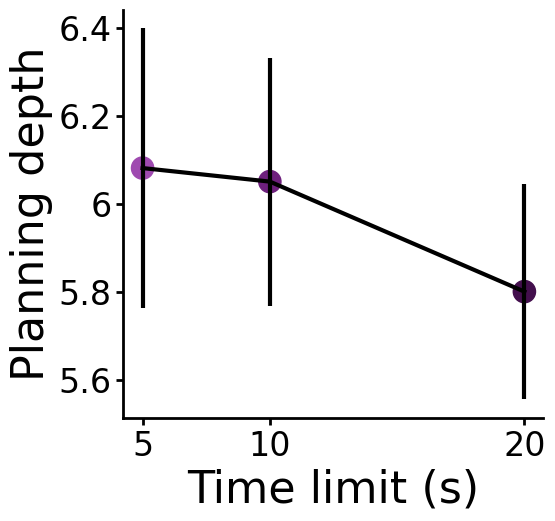

In [24]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plot_with_errorbars(fig,ax,[5,10,20],np.mean(depth_time_rep,axis=2),colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Planning depth')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3f.pdf')
plt.show()

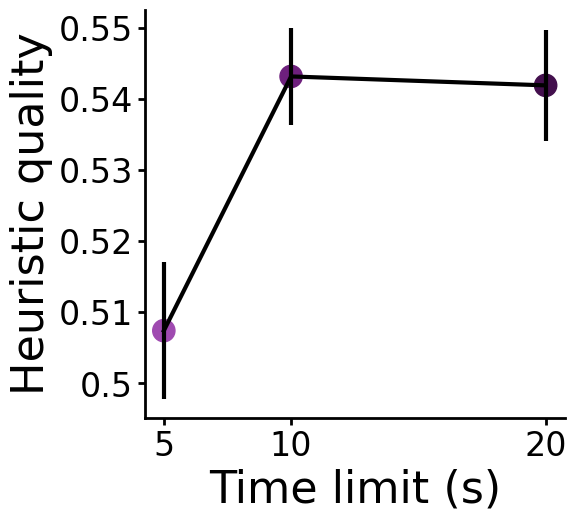

In [25]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,[5,10,20],np.mean(heuristic_quality_time_rep,axis=2),colors=time_colors)
#plot_with_errorbars(fig,ax,[5,10,20],np.mean(heuristic_quality_time_rep,axis=2)[condition=='random'],colors=time_colors)
#plot_with_errorbars(fig,ax,[5,10,20],np.mean(heuristic_quality_time_rep,axis=2)[condition!='random'],colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Heuristic quality')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3f.pdf')
plt.show()

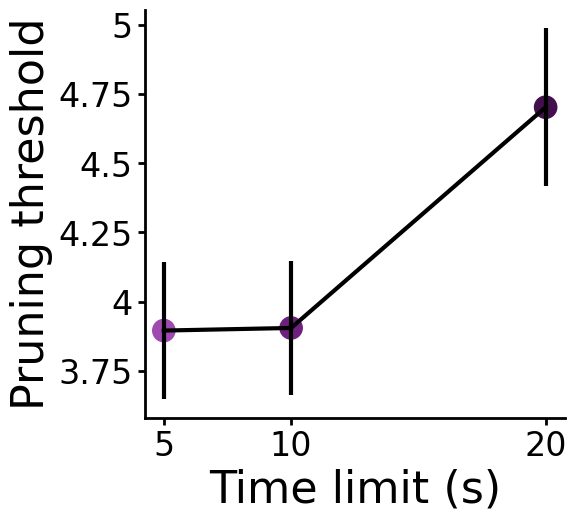

In [26]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
 
plot_with_errorbars(fig,ax,[5,10,20],np.nanmean(params_time_rep[:,:,:,1],axis=2),colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Pruning threshold')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3f.pdf')
plt.show()

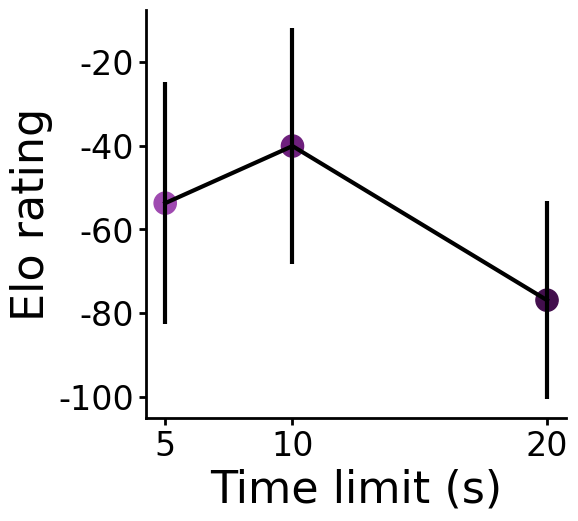

In [27]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plot_with_errorbars(fig,ax,[5,10,20],ratings_time,colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Elo rating')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3f.pdf')
plt.show()

In [44]:
#pd.DataFrame(np.mean(np.reshape(load_params_file('C:/Users/svo/Documents/fmri/params_fmri_final.txt'),[-1,5,10]),axis=1),
#            columns=['pruning_thresh','stopping_prob','feature_drop_rate','lapse_rate','active_scaling_constant','center_weight',
#                    '2conn_weight','2unconn_weight','3inarow_weight','4inarow_weight']).to_csv('C:/Users/svo/Documents/fmri/params_fmri.csv')

In [35]:
peak_rts = [get_peak_rt(i) for i in range(5000)]
peak_user_ids = [get_peak_user_id(i) for i in range(5000)]

In [36]:
#np.savetxt(peak_direc + 'params_peak_final.txt',np.vstack([expand_params(np.loadtxt(peak_direc + 'splits/' + str(i+1) + '/params' + str(j) + '.csv',delimiter=',')) 
#                                              for i in range(5000) for j in range(1,6)]),fmt='%.5f')

In [37]:
ratings_peak = np.reshape(np.array([rating_dict[u] for u in peak_user_ids]),[-1,5])

In [38]:
np.savetxt(direc + 'ratings_peak.csv',ratings_peak)

In [39]:
params_peak = np.array([[expand_params(load_params_file(peak_direc + 'splits/' + str(i+1) + '/params' + str(j+1) + '.csv')) 
                                       for j in range(5)]
                        for i in range(0,5000)])
params_peak = np.reshape(params_peak,[-1,5,5,58]) 
feature_drop_rate_peak = params_peak[:,:,:,-1]

In [40]:
params_learn = np.reshape(np.loadtxt(direc + 'Params/params_learn_final.txt'),[30,5,5,58])
params_time = np.reshape(np.loadtxt(direc + 'Params/params_tai_final.txt'),[30,3,5,58])
feature_drop_rate_learn = params_learn[:,:,:,-1]
feature_drop_rate_time = params_time[:,:,:,-1]


In [41]:
filename = direc + 'Learning/depth_learn.npy'
if os.path.exists(filename):
    depth_learn = np.load(filename,allow_pickle=True)
else: 
    depth_learn = np.reshape([[np.mean(np.loadtxt(direc + 'Learning/splits/'+str(i)+'/pv_depth_' + str(j) + '.txt'))
                           for j in range(1,6)] for i in range(0,150)],[30,5,5])
    np.save(filename,depth_learn,allow_pickle=True)

In [42]:
filename = direc + 'Timed AI/depth_time.npy'
if os.path.exists(filename):
    depth_time = np.load(filename,allow_pickle=True)
else: 
    depth_time = np.reshape([[np.mean(np.loadtxt(direc + 'Timed AI/splits/'+str(i)+'/pv_depth_' + str(j) + '.txt'))
                           for j in range(1,6)] for i in range(0,90)],[30,3,5])
    np.save(filename,depth_time,allow_pickle=True)

In [43]:
filename = direc + 'Peak/depth_peak.npy'
if os.path.exists(filename):
    depth_peak = np.load(filename,allow_pickle=True)
else: 
    depth_peak = np.reshape([[np.mean(np.loadtxt(peak_direc + 'depth/depth_peak_final_'+str(i)+'_' + str(j) + '.txt'))
                       for j in range(1,6)] for i in range(5000)],[-1,5,5])    
    np.save(filename,depth_peak,allow_pickle=True)

In [44]:
heuristic_quality_learn = np.apply_along_axis(get_heuristic_quality,arr=params_learn,axis=3)
heuristic_quality_time = np.apply_along_axis(get_heuristic_quality,arr=params_time,axis=3)
heuristic_quality_peak = np.apply_along_axis(get_heuristic_quality,arr=params_peak,axis=3)
#heuristic_quality_time = get_heuristic_quality(params_time)
#heuristic_quality_peak = np.vstack([get_heuristic_quality(params_peak[100*i:100*(i+1)]) for i in range(10)])

In [45]:
np.save(direc + 'heuristic_quality_peak.txt',heuristic_quality_peak)
np.save(direc + 'planning_depth_peak.txt',depth_peak)
np.save(direc + 'feature_drop_rate_peak.txt',feature_drop_rate_peak)


In [46]:
#sts.spearmanr(np.mean(depth_learn,axis=2).flatten(),np.reshape(thinking_time,[-1,5]).flatten())

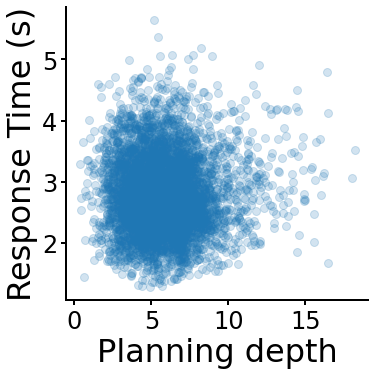

In [47]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax.plot(np.mean(depth_peak,axis=2),np.reshape(peak_rts,[-1,5]),'.',alpha=0.2,color='C0')
ax.set_xlabel('Planning depth')
ax.set_ylabel('Response Time (s)')
#ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3a.pdf')
plt.show()

In [48]:
sts.pearsonr(np.mean(depth_peak,axis=2).flatten(),np.reshape(peak_rts,[-1,5]).flatten())

(0.011340774645487411, 0.4227038676729747)

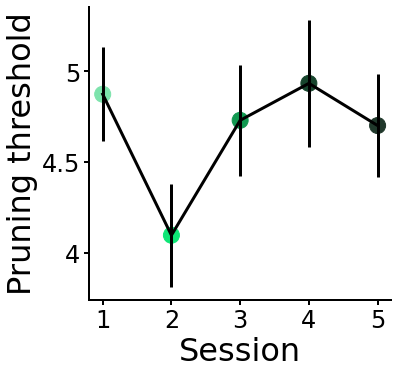

In [49]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),np.mean(params_learn[:,:,:,1],axis=2),colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Pruning threshold')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3a.pdf')
plt.show()

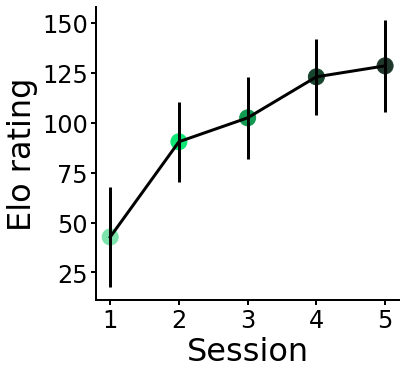

In [50]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),ratings_learn,colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Elo rating')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3a.pdf')
plt.show()

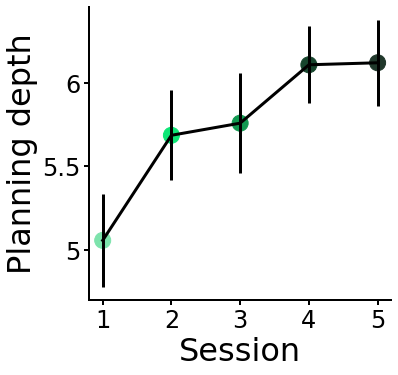

In [51]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),np.mean(depth_learn,axis=2),colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Planning depth')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3b.pdf')
plt.show()

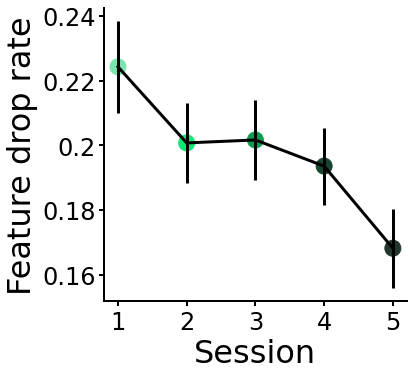

In [52]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),np.mean(feature_drop_rate_learn,axis=2),colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Feature drop rate')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3c.pdf')
plt.show()

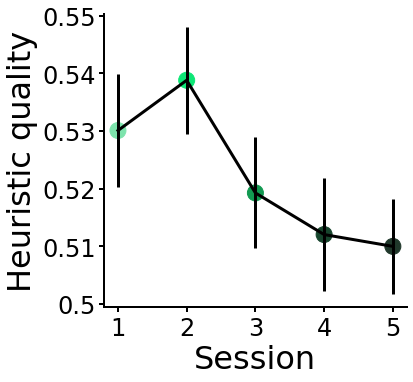

In [53]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),np.mean(heuristic_quality_learn,axis=2),colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Heuristic quality')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3d.pdf')
plt.show()

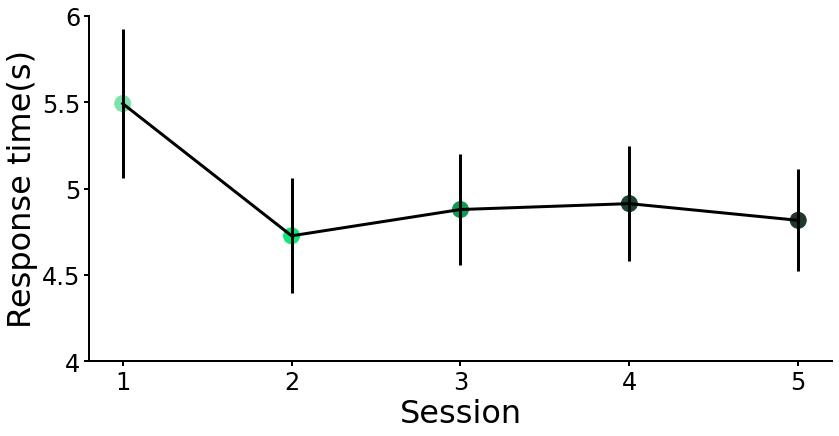

In [54]:
T = np.loadtxt(direc + 'Learning/time_learn.txt')
thinking_time = [np.mean(T[T[:,0]==i,1])/1000 for i in range(150)]

fig,ax=plt.subplots(figsize=(12,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),np.reshape(thinking_time,[30,5]),colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Response time(s)')
ax.set_xticks(range(1,6))
ax.set_yticks(np.arange(4,6.5,0.5))
fig.subplots_adjust(bottom=0.15,right=0.98,left=0.12,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_16.pdf')
plt.show()

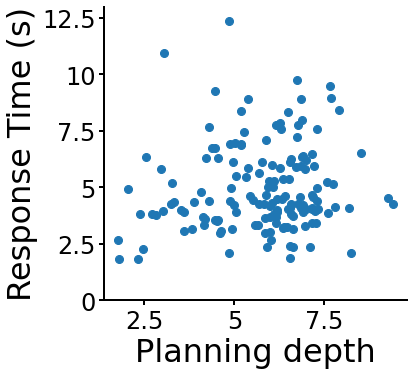

In [55]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax.plot(np.mean(depth_learn,axis=2),np.reshape(thinking_time,[30,5]),'.',color='C0')
ax.set_xlabel('Planning depth')
ax.set_ylabel('Response Time (s)')
ax.set_ylim([0,13])
#ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3a.pdf')
plt.show()

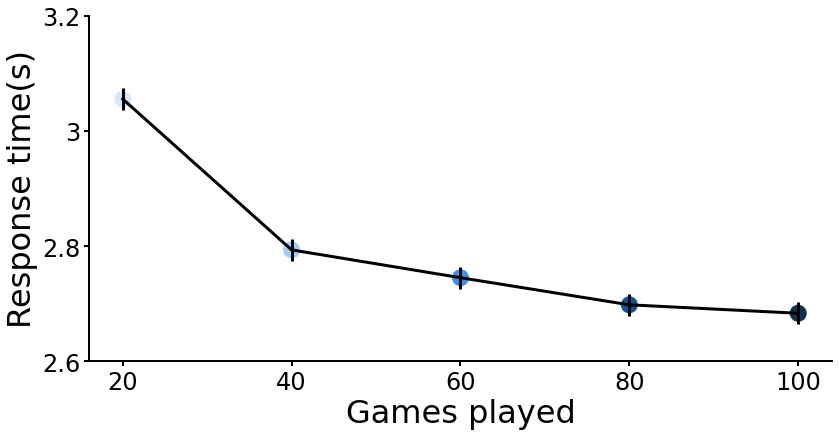

In [56]:
fig,ax=plt.subplots(figsize=(12,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,np.arange(20,120,20),np.reshape(peak_rts,[1000,5]),colors=peak_colors)
ax.set_xlabel('Games played')
ax.set_xticks(np.arange(20,120,20))
ax.set_ylabel('Response time(s)')
ax.set_yticks(np.arange(2.6,3.4,0.2))
fig.subplots_adjust(bottom=0.15,right=0.98,left=0.12,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_17.pdf')
plt.show()

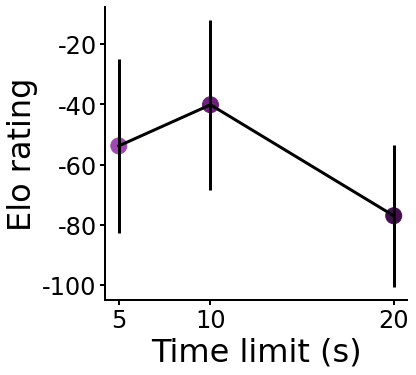

In [57]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,[5,10,20],ratings_time,colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Elo rating')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3e.pdf')
plt.show()

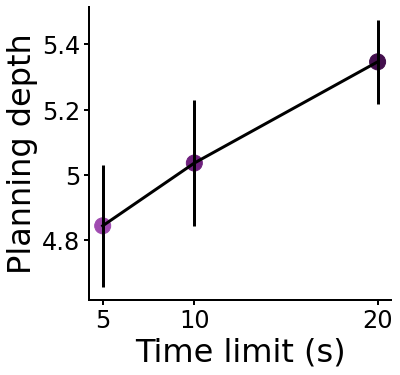

In [68]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

#plot_with_errorbars(fig,ax,[5,10,20],np.mean(depth_time,axis=2),colors=time_colors)
plot_with_errorbars(fig,ax,[5,10,20],-np.mean(np.log(params_time[:,:,:,2]),axis=2),colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Planning depth')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3f.pdf')
plt.show()

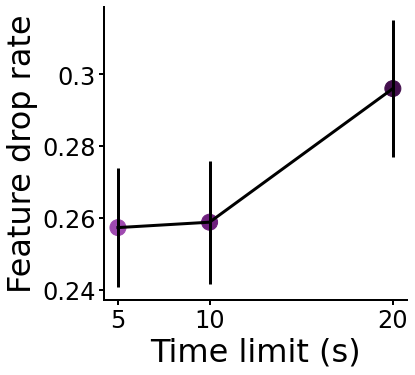

In [59]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,[5,10,20],np.mean(feature_drop_rate_time,axis=2),colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Feature drop rate')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3g.pdf')
plt.show()

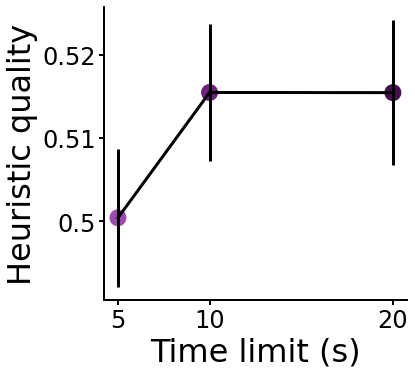

In [60]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,[5,10,20],np.mean(heuristic_quality_time,axis=2),colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Heuristic quality')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3h.pdf')
plt.show()

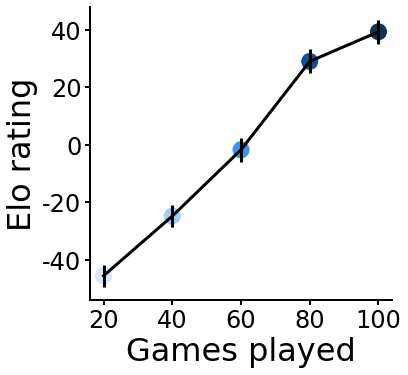

In [61]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,np.arange(20,120,20),ratings_peak,colors=peak_colors)
ax.set_xlabel('Games played')
ax.set_ylabel('Elo rating')
ax.set_xticks(np.arange(20,120,20))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_4a.pdf')
plt.show()

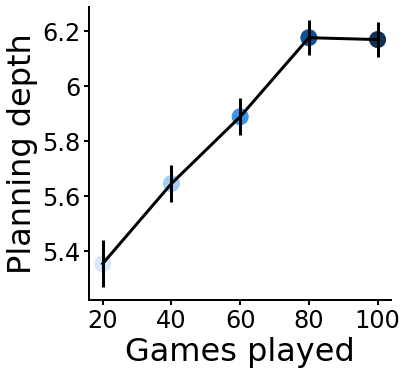

In [62]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,np.arange(20,120,20),np.mean(depth_peak,axis=2),colors=peak_colors)
ax.set_xlabel('Games played')
ax.set_ylabel('Planning depth')
ax.set_xticks(np.arange(20,120,20))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_4b.pdf')
plt.show()

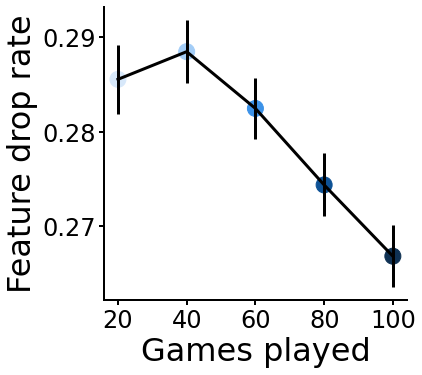

In [63]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,np.arange(20,120,20),np.mean(feature_drop_rate_peak,axis=2),colors=peak_colors)
ax.set_xlabel('Games played')
ax.set_ylabel('Feature drop rate')
ax.set_xticks(np.arange(20,120,20))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_4c.pdf')
plt.show()

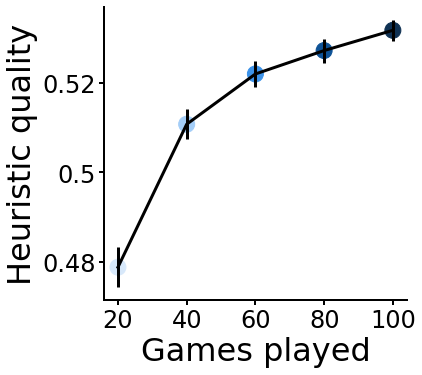

In [76]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,np.arange(20,120,20),np.mean(heuristic_quality_peak,axis=2),colors=peak_colors)
ax.set_xlabel('Games played')
ax.set_ylabel('Heuristic quality')
ax.set_xticks(np.arange(20,120,20))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_4d.pdf')
plt.show()

In [77]:
sts.ttest_ind(np.mean(heuristic_quality_learn,axis=2)[:,0],np.mean(heuristic_quality_peak,axis=2)[:,0],equal_var = False)

Ttest_indResult(statistic=4.686441448232725, pvalue=3.011118458877471e-05)

In [78]:
np.mean(np.mean(heuristic_quality_learn,axis=2)[:,0]),np.std(np.mean(heuristic_quality_learn,axis=2)[:,0])/np.sqrt(30)

(0.5300678266288997, 0.009835984667459713)

In [79]:
np.mean(np.mean(heuristic_quality_peak,axis=2)[:,0]),np.std(np.mean(heuristic_quality_peak,axis=2)[:,0])/np.sqrt(1000)

(0.4788243935709595, 0.004411233039923336)

In [80]:
print('depth')
for x,y in zip([range(5),[5,10,20],range(5)],[depth_learn,depth_time,depth_peak]):
    print(sts.pearsonr(np.tile(x,[y.shape[0],1]).flatten(),np.mean(y,axis=2).flatten()))
    print(sts.spearmanr(np.tile(x,[y.shape[0],1]).flatten(),np.mean(y,axis=2).flatten()))

print('feature drop rate')
for x,y in zip([range(5),[5,10,20],range(5)],[feature_drop_rate_learn,feature_drop_rate_time,feature_drop_rate_peak]):
    print(sts.pearsonr(np.tile(x,[y.shape[0],1]).flatten(),(np.mean(y,axis=2)-np.mean(y,axis=(1,2))[:,None]).flatten()))
    print(sts.spearmanr(np.tile(x,[y.shape[0],1]).flatten(),np.mean(y,axis=2).flatten()))

print('heuristic quality')
for x,y in zip([range(5),[5,10,20],range(5)],[heuristic_quality_learn,heuristic_quality_time,heuristic_quality_peak]):
    print(sts.pearsonr(np.tile(x,[y.shape[0],1]).flatten(),np.mean(y,axis=2).flatten()))
    print(sts.spearmanr(np.tile(x,[y.shape[0],1]).flatten(),np.mean(y,axis=2).flatten()))


depth
(0.23706751200183332, 0.0034897655202440238)
SpearmanrResult(correlation=0.21022532476198413, pvalue=0.00981991648760663)
(0.181788722093129, 0.08637975483861456)
SpearmanrResult(correlation=0.22943102963134362, pvalue=0.02961110147144177)
(0.13677189344505544, 2.6153561805791774e-22)
SpearmanrResult(correlation=0.18702961732265772, pvalue=1.3627225161070281e-40)
feature drop rate
(-0.3642710248403179, 4.5941180449208176e-06)
SpearmanrResult(correlation=-0.2733691302316634, pvalue=0.0007123648447403557)
(0.3313762164337118, 0.0014206612846463815)
SpearmanrResult(correlation=0.14876349866507213, pvalue=0.16170306067234747)
(-0.08716630939973688, 6.666738334469198e-10)
SpearmanrResult(correlation=-0.09633662093885091, pvalue=8.718969992066146e-12)
heuristic quality
(-0.1806716674034853, 0.02693237423063473)
SpearmanrResult(correlation=-0.18159287504038812, pvalue=0.026150564364931496)
(0.11473825278818037, 0.2815481457635414)
SpearmanrResult(correlation=0.1403824564867582, pvalue=0

In [100]:
#plt.plot(heuristic_values[0,0,0,player_color==0],optimal_board_values[player_color==0],'.',alpha=0.5)
#plt.plot(heuristic_values[0,0,0,player_color==1],optimal_board_values[player_color==1],'.',alpha=0.5)
#plt.show()

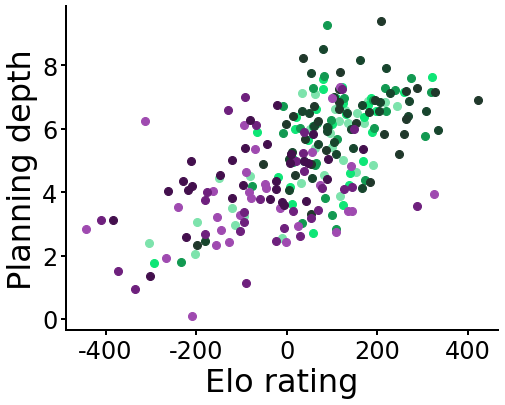

(0.6175372308696662, 1.2630336060629242e-26)

In [101]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(learn_colors):
    ax.plot(ratings_learn[:,i],np.mean(depth_learn,axis=2)[:,i],'.',color=c)
for i,c in enumerate(time_colors):
    ax.plot(ratings_time[:,i],np.mean(depth_time,axis=2)[:,i],'.',color=c)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Planning depth')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.2,top=0.95)
fig.savefig(fig_direc + 'supp_figure_14A.pdf')
plt.show()
sts.pearsonr(np.hstack([ratings_learn,ratings_time]).flatten(),
             np.hstack([np.mean(depth_learn,axis=2),np.mean(depth_time,axis=2)]).flatten())

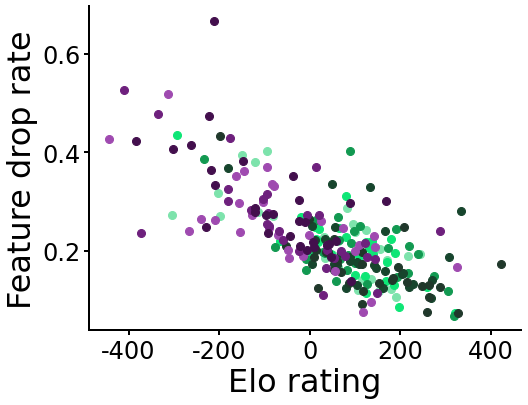

(-0.7355582234600877, 3.940921167437628e-42)

In [102]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(learn_colors):
    ax.plot(ratings_learn[:,i].flatten(),np.mean(feature_drop_rate_learn,axis=2)[:,i],'.',color=c,alpha=1)
for i,c in enumerate(time_colors):
    ax.plot(ratings_time[:,i].flatten(),np.mean(feature_drop_rate_time,axis=2)[:,i],'.',color=c,alpha=1)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Feature drop rate')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.2,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_14B.pdf')
plt.show()
sts.pearsonr(np.hstack([ratings_learn,ratings_time]).flatten(),
             np.hstack([np.mean(feature_drop_rate_learn,axis=2),np.mean(feature_drop_rate_time,axis=2)]).flatten())

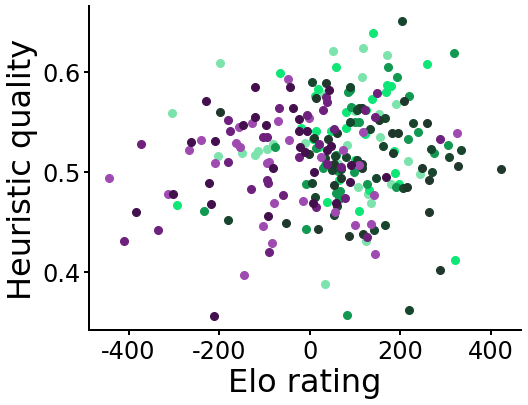

(0.1094144215489003, 0.09078473284131039)

In [103]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(learn_colors):
    ax.plot(ratings_learn[:,i].flatten(),np.mean(heuristic_quality_learn,axis=2)[:,i],'.',color=c)
for i,c in enumerate(time_colors):
    ax.plot(ratings_time[:,i].flatten(),np.mean(heuristic_quality_time,axis=2)[:,i],'.',color=c)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Heuristic quality')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.2,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_14C.pdf')
plt.show()
sts.pearsonr(np.hstack([ratings_learn,ratings_time]).flatten(),
             np.hstack([np.mean(heuristic_quality_learn,axis=2),np.mean(heuristic_quality_time,axis=2)]).flatten())

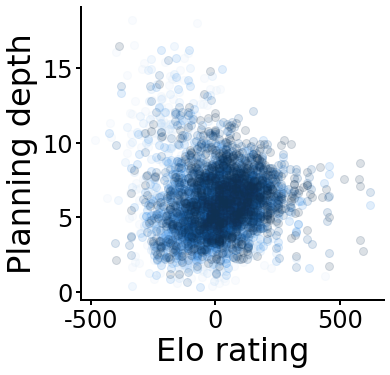

(0.024364600361867612, 0.08494960063781906)

In [104]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(peak_colors):
    ax.plot(ratings_peak[:,i].flatten(),np.mean(depth_peak,axis=2)[:,i],'.',color=c,alpha=0.15)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Planning depth')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_1b.pdf')
plt.show()
sts.pearsonr(ratings_peak.flatten(),np.mean(depth_peak,axis=2).flatten())

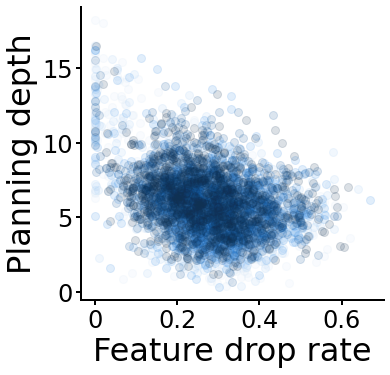

(-0.37981059985557863, 2.5097827259902357e-171)

In [106]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(peak_colors):
    ax.plot(np.mean(feature_drop_rate_peak,axis=2)[:,i],np.mean(depth_peak,axis=2)[:,i],'.',color=c,alpha=0.15)

ax.set_xlabel('Feature drop rate')
ax.set_ylabel('Planning depth')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'supp_figure_1b.pdf')
plt.show()
sts.pearsonr(np.mean(feature_drop_rate_peak,axis=2).flatten(),np.mean(depth_peak,axis=2).flatten())

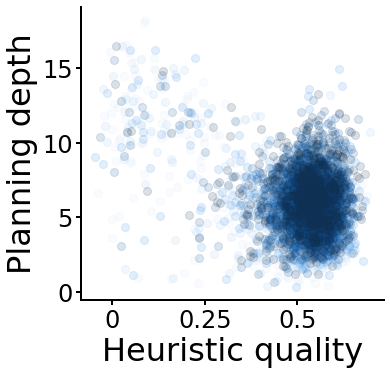

(-0.20685556420377846, 1.8744374027634853e-49)

In [107]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(peak_colors):
    ax.plot(np.mean(heuristic_quality_peak,axis=2)[:,i],np.mean(depth_peak,axis=2)[:,i],'.',color=c,alpha=0.15)

ax.set_xlabel('Heuristic quality')
ax.set_ylabel('Planning depth')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_1b.pdf')
plt.show()
sts.pearsonr(ratings_peak.flatten(),np.mean(feature_drop_rate_peak,axis=2).flatten())

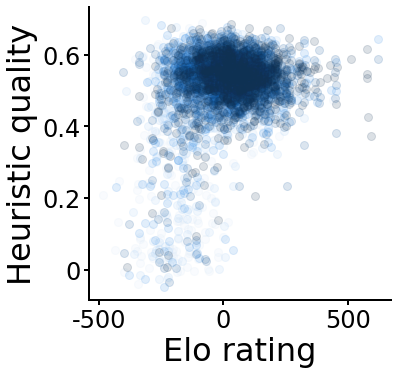

(0.2659662658690517, 1.0087957133959786e-81)

In [108]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(peak_colors):
    ax.plot(ratings_peak[:,i].flatten(),np.mean(heuristic_quality_peak,axis=2)[:,i],'.',color=c,alpha=0.15)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Heuristic quality')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_1c.pdf')
plt.show()
sts.pearsonr(ratings_peak.flatten(),np.mean(heuristic_quality_peak,axis=2).flatten())

In [ ]:
d1 = np.mean(np.reshape([[np.mean(np.loadtxt(direc + 'Planning depth/depth/depth_hvh_final_' + str(i) + '_' + str(j) + '.txt'))
                           for j in range(1,6)] for i in range(0,40)],[40,5]),axis=1)
d2 = np.mean(np.reshape([[np.mean(np.loadtxt(direc + 'Planning depth/depth/depth_hvh_final2_' + str(i) + '_' + str(j) + '.txt'))
                           for j in range(1,6)] for i in range(0,40)],[40,5]),axis=1)

In [ ]:
f1 = np.mean(np.reshape(np.loadtxt(direc + 'Params/params_hvh_final.txt')[:,-1],[40,5]),axis=1)
f2 = np.mean(np.reshape(np.loadtxt(direc + 'Params/params_hvh_final2.txt')[:,-1],[40,5]),axis=1)

In [ ]:
q1 = np.mean(np.apply_along_axis(get_heuristic_quality,arr=np.reshape(np.loadtxt(direc + 'Params/params_hvh_final.txt'),[40,5,58]),axis=2),axis=1)
q2 = np.mean(np.apply_along_axis(get_heuristic_quality,arr=np.reshape(np.loadtxt(direc + 'Params/params_hvh_final2.txt'),[40,5,58]),axis=2),axis=1)

In [ ]:
sts.pearsonr(d1,d2),sts.pearsonr(f1,f2),sts.pearsonr(q1,q2)

In [ ]:
def plot_param_bars(rho,sem,names,xlabel,c,filename):
    fig,ax = plt.subplots(figsize=(8,6))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_xlim([0,1])
    ax.set_xlabel(xlabel,usetex=False)
    ax.barh(range(len(rho),0,-1), rho, xerr=sem, align='center',
        color=c, ecolor='black')
    plt.xticks(np.arange(0,1.2,0.5))
    plt.yticks(range(len(rho),0,-1),names, fontsize =18)
    fig.subplots_adjust(bottom=0.2,right=0.95,left=0.3)
    fig.savefig(fig_direc + filename)
    plt.show()

In [ ]:
plot_param_bars(rho = [sts.pearsonr(d1,d2)[0],sts.pearsonr(f1,f2)[0],sts.pearsonr(q1,q2)[0]],sem=[0,0,0],
                names = ['Planning depth','Feature drop rate','Heuristic quality'],
                xlabel = 'Correlation: repeated fits          ',
                c='red',filename='supp_figure_5A.pdf')

In [ ]:
def plot_correlation_across_conditions(stats,names,xlabel,color,fig_name):
    rho = [np.mean(np.corrcoef(np.mean(x,axis=2).T)[np.triu_indices(x.shape[1],1)]) for x in stats]
    sem = [np.std(np.corrcoef(np.mean(x,axis=2).T)[np.triu_indices(x.shape[1],1)])/np.sqrt(10) for x in stats]
    plot_param_bars(rho,sem,names,xlabel,color,fig_name)
    print(rho,sem,[sts.ttest_1samp(np.corrcoef(np.mean(x,axis=2).T)[np.triu_indices(x.shape[1],1)],popmean=0) for x in stats])

plot_correlation_across_conditions([depth_learn,feature_drop_rate_learn,heuristic_quality_learn],
                               ['Planning depth','Feature drop rate','Heuristic quality'],
                               'Correlation: learning       ',learn_colors[2],'supp_figure_5B.pdf')

In [ ]:
#for name,x in zip(['depth','feature drop rate','heuristic quality'],
#                  [depth_time,feature_drop_rate_time,heuristic_quality_time]):
#    print(name)
#    print('correlation across groups')
#    print(np.corrcoef(np.reshape(x,[90,5]).T))
#    print('correlation across sessions')
#    plt.imshow(np.corrcoef(np.mean(x,axis=2).T),vmin=-1,vmax=1,cmap='bwr')
#    plt.show()
#    print(np.corrcoef(np.mean(x,axis=2).T))

In [ ]:
plt.imshow(np.corrcoef(ratings_peak.T),vmin=-1,vmax=1,cmap='bwr')
plt.show()

for name,x in zip(['depth','feature drop rate','heuristic quality'],
                  [depth_peak,feature_drop_rate_peak,heuristic_quality_peak]):
    print(name)
    print('correlation across groups')
    print(np.corrcoef(np.reshape(x,[-1,5]).T))
    print('correlation across games played')
    plt.imshow(np.corrcoef(np.mean(x,axis=2).T),vmin=-1,vmax=1,cmap='bwr')
    plt.show()

In [69]:
import pandas as pd
import statsmodels.formula.api as sm

def get_slopes(elo,tree,feat,qual):
    p = sm.ols(formula="y ~ tree + feat + qual",
               data=pd.DataFrame({'y' : elo,'tree': tree,'feat' : feat,'qual' : qual})
              ).fit().params
    return [p[x] for x in ['tree','feat','qual','Intercept']]

In [70]:
slopes = [get_slopes(ratings_learn[:,i],np.mean(depth_learn,axis=2)[:,i],
                     np.mean(feature_drop_rate_learn,axis=2)[:,i],np.mean(heuristic_quality_learn,axis=2)[:,i])
                 for i in range(5)]
ratings_learn_pred = np.mean(np.sum([s*A for s,A in zip(np.mean(slopes,axis=0),
                                                [depth_learn,feature_drop_rate_learn,heuristic_quality_learn])],axis=0),axis=2)
ratings_learn_pred += np.mean(slopes,axis=0)[-1]

In [71]:
list(zip(np.mean(slopes,axis=0),np.std(slopes,axis=0)/np.sqrt(5)))

[(32.60162098299453, 4.685471469331397),
 (-783.7789087390702, 108.31496854220615),
 (309.0959748043232, 151.69454394978717),
 (-94.89512768811831, 92.97114096236687)]

In [72]:
np.array(slopes)

array([[   52.28509863,  -650.30542716,   229.54137519,  -197.40769032],
       [   21.551189  , -1077.87020676,   149.2602535 ,   103.98266923],
       [   29.55629449,  -719.88885593,   963.06801014,  -422.51392317],
       [   32.49145443,  -435.21644313,   223.84210485,  -105.67333661],
       [   27.12406835, -1035.61361071,   -20.23186965,   147.13664243]])

In [73]:
print(np.mean(ratings_learn[:,-1]-ratings_learn[:,0]),np.std(ratings_learn[:,-1]-ratings_learn[:,0])/np.sqrt(30))

for s,x in zip(np.mean(slopes,axis=0),[depth_learn,feature_drop_rate_learn,heuristic_quality_learn]):
    print(s,s*np.mean(x[:,-1]-x[:,0]),np.abs(s)*np.std(np.mean(x[:,-1,:]-x[:,0,:],axis=1))/np.sqrt(x.shape[0]))

85.83333333333333 24.947415066866512
32.60162098299453 34.65155683207491 10.86180507282543
-783.7789087390702 43.94905449781852 11.649984686130939
309.0959748043232 -6.217269450555391 3.3264040964117605


In [74]:
slopes = [get_slopes(ratings_time[:,i],np.mean(depth_time,axis=2)[:,i],
                     np.mean(feature_drop_rate_time,axis=2)[:,i],np.mean(heuristic_quality_time,axis=2)[:,i])
                 for i in range(3)]
ratings_time_pred = np.mean(np.sum([s*A for s,A in zip(np.mean(slopes,axis=0),
                                                [depth_time,feature_drop_rate_time,heuristic_quality_time])],axis=0),axis=2)
ratings_time_pred += np.mean(slopes,axis=0)[-1]

In [75]:
print(np.mean(ratings_time[:,-1]-ratings_time[:,0]),np.std(ratings_time[:,-1]-ratings_time[:,0])/np.sqrt(1000))

for s,x in zip(np.mean(slopes,axis=0),[depth_time,feature_drop_rate_time,heuristic_quality_time]):
    print(s,s*np.mean(x[:,-1]-x[:,0]),np.abs(s)*np.std(np.mean(x[:,-1,:]-x[:,0,:],axis=1))/np.sqrt(x.shape[0]))

-23.166666666666668 4.031873702827949
25.066762193818978 15.040061584012058 6.559843114907055
-1052.6628064430454 -40.77169371263978 15.481364175765163
-377.9880133876595 -5.677918101424919 3.4623119286986106


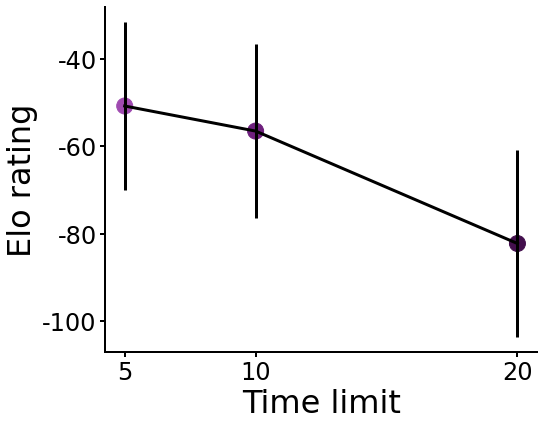

In [76]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,[5,10,20],ratings_time_pred,colors=time_colors)
#plot_with_errorbars(fig,ax,range(1,6),ratings_learn,colors=learn_colors)
ax.set_xlabel('Time limit')
ax.set_ylabel('Elo rating')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.15,right=0.95,left=0.2,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_rev2_1B.pdf')
plt.show()

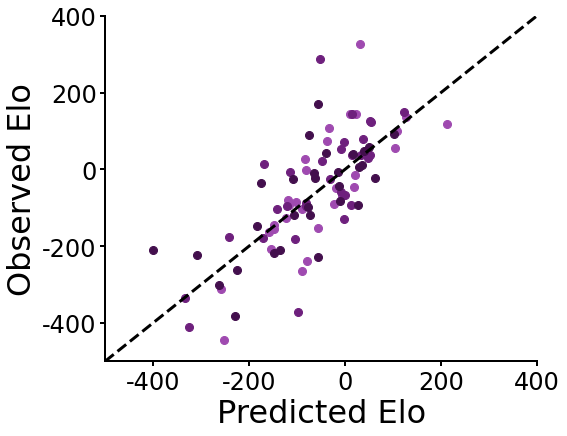

In [77]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i in range(3):
    ax.plot(ratings_time_pred[:,i],ratings_time[:,i],'.',color=time_colors[i])
ax.plot([-500,400],[-500,400],color='black',linestyle='dashed')
ax.set_xlabel('Predicted Elo')
ax.set_ylabel('Observed Elo')
ax.set_xlim([-500,400])
ax.set_ylim([-500,400])
fig.subplots_adjust(bottom=0.15,right=0.95,left=0.2,top=0.95)
fig.savefig(fig_direc + 'supp_figure_rev2_1A.pdf')
plt.show()

In [78]:
sts.pearsonr(ratings_time_pred.flatten(),ratings_time.flatten())

(0.7408278674458506, 7.01466978895127e-17)

In [79]:
slopes = [get_slopes(ratings_peak[:,i],np.mean(depth_peak,axis=2)[:,i],
                     np.mean(feature_drop_rate_peak,axis=2)[:,i],np.mean(heuristic_quality_peak,axis=2)[:,i])
                 for i in range(5)]
ratings_peak_pred = np.mean(np.sum([s*A for s,A in zip(np.mean(slopes,axis=0),
                                                [depth_peak,feature_drop_rate_peak,heuristic_quality_peak])],axis=0),axis=2)
ratings_peak_pred += np.mean(slopes,axis=0)[-1]

In [80]:
print(np.mean(ratings_peak[:,-1]-ratings_peak[:,0]),np.std(ratings_peak[:,-1]-ratings_peak[:,0])/np.sqrt(1000))

for s,x in zip(np.mean(slopes,axis=0),[depth_peak,feature_drop_rate_peak,heuristic_quality_peak]):
    print(s,s*np.mean(x[:,-1]-x[:,0]),np.abs(s)*np.std(np.mean(x[:,-1,:]-x[:,0,:],axis=1))/np.sqrt(x.shape[0]))

84.902 4.262655322214077
1.1101738686897575 0.9056271727832292 0.11359042933943805
-327.9963155607341 6.142314022961839 1.5217288873293415
334.2026573494911 17.685102812904073 1.470905621129678


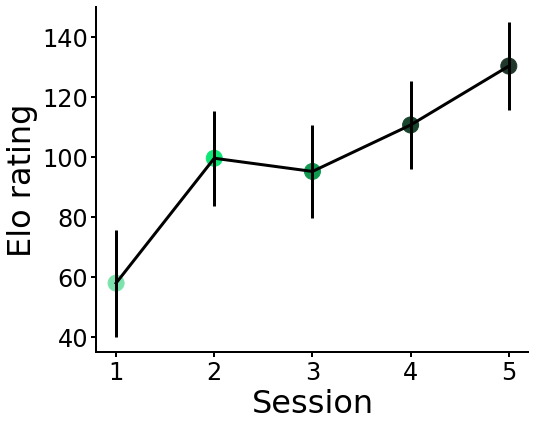

In [81]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),ratings_learn_pred,colors=learn_colors)
#plot_with_errorbars(fig,ax,range(1,6),ratings_learn,colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Elo rating')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.15,right=0.95,left=0.2,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_14B.pdf')
plt.show()

In [82]:
1-np.sum((ratings_learn_pred-ratings_learn)**2)/np.sum((ratings_learn-np.mean(ratings_learn))**2)

0.5686258516350899

In [83]:
sts.pearsonr(ratings_learn_pred.flatten(),ratings_learn.flatten())

(0.7545654819645969, 7.244391619232826e-29)

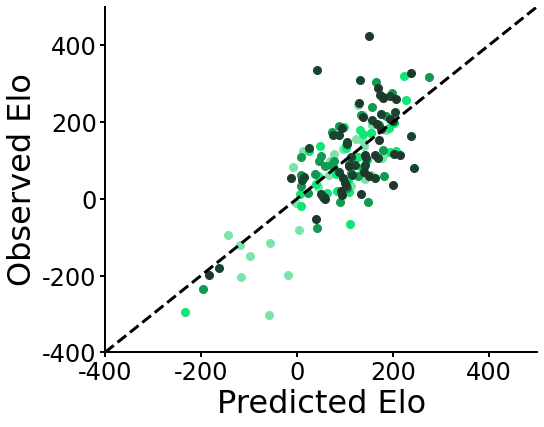

In [84]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i in range(5):
    ax.plot(ratings_learn_pred[:,i],ratings_learn[:,i],'.',color=learn_colors[i])
ax.plot([-400,500],[-400,500],color='black',linestyle='dashed')
ax.set_xlabel('Predicted Elo')
ax.set_ylabel('Observed Elo')
ax.set_xlim([-400,500])
ax.set_ylim([-400,500])
fig.subplots_adjust(bottom=0.15,right=0.95,left=0.2,top=0.95)
fig.savefig(fig_direc + 'supp_figure_14A.pdf')
plt.show()

In [ ]:
def test_significance(A,x):
    df = pd.DataFrame({'y' : A.flatten(),'subj': np.repeat(range(A.shape[0]),A.shape[1]),'cond' : np.tile(x,A.shape[0])})
    res = sm.ols(formula="y ~ cond + C(subj)",data=df).fit()
    return res.params['cond'],np.mean((res.conf_int(alpha=0.05).loc['cond'].values-res.params['cond'])*[-1,1]),res.pvalues['cond']

def test_significance_categorical(A,x):
    df = pd.DataFrame({'y' : A.flatten(),'subj': np.repeat(range(A.shape[0]),A.shape[1]),'cond' : np.tile(x,A.shape[0])})
    res = sm.ols(formula="y ~ C(cond) + C(subj)",data=df).fit()
    return res
    #return res.params['cond'],np.mean((res.conf_int(alpha=0.05).loc['cond'].values-res.params['cond'])*[-1,1]),res.pvalues['cond']


In [ ]:
A = np.mean(depth_learn,axis=2)


In [ ]:
direc

In [ ]:
for name,x in zip(['depth','feature drop rate','heuristic quality'],
                  [depth_learn,feature_drop_rate_learn,heuristic_quality_learn]):
    #print(name,test_significance(np.mean(x,axis=2),range(5)))
    A = np.mean(x,axis=2)
    df = pd.DataFrame({'y' : A.flatten(),'subj': np.repeat(range(A.shape[0]),A.shape[1]),'cond' : np.tile(range(5),A.shape[0])})
    df.to_csv(direc + 'Regressions/' + name + '_session.csv')


In [ ]:
for name,x in zip(['depth','feature drop rate','heuristic quality'],
                  [depth_time,feature_drop_rate_time,heuristic_quality_time]):
    #print(name,test_significance(np.mean(x,axis=2),[5,10,20]))
    A = np.mean(x,axis=2)
    df = pd.DataFrame({'y' : A.flatten(),'subj': np.repeat(range(A.shape[0]),A.shape[1]),'cond' : np.tile([5,10,20],A.shape[0])})
    df.to_csv(direc + 'Regressions/' + name + '_time.csv')



In [ ]:
for name,x in zip(['depth','feature drop rate','heuristic quality'],
                  [depth_peak,feature_drop_rate_peak,heuristic_quality_peak]):
    #print(name,test_significance(np.mean(x,axis=2),range(5)))
    A = np.mean(x,axis=2)
    df = pd.DataFrame({'y' : A.flatten(),'subj': np.repeat(range(A.shape[0]),A.shape[1]),'cond' : np.tile(np.arange(20,120,20),A.shape[0])})
    df.to_csv(direc + 'Regressions/' + name + '_peak.csv')



In [ ]:
A = ratings_learn
df = pd.DataFrame({'y' : A.flatten(),'subj': np.repeat(range(A.shape[0]),A.shape[1]),'cond' : np.tile(range(5),A.shape[0])})
df.to_csv(direc + 'Regressions/elo_session.csv')


In [ ]:
A = ratings_time
df = pd.DataFrame({'y' : A.flatten(),'subj': np.repeat(range(A.shape[0]),A.shape[1]),'cond' : np.tile([5,10,20],A.shape[0])})
df.to_csv(direc + 'Regressions/elo_time.csv')


In [ ]:
A = ratings_peak
df = pd.DataFrame({'y' : A.flatten(),'subj': np.repeat(range(A.shape[0]),A.shape[1]),'cond' : np.tile(np.arange(20,120,20),A.shape[0])})
df.to_csv(direc + 'Regressions/elo_peak.csv')


In [ ]:
test_significance(ratings_learn,range(5))

In [ ]:
test_significance(ratings_time,[5,10,20])

In [ ]:
sts.f(ratings_time[:,0],ratings_time[:,1],ratings_time[:,2])

In [ ]:
models=['final','final_nonoise','final_nodelta','final_noprune','final_notree','final_noact','final_no3',
        'final_no2conn','final_nocenter','final_no4','final_no2unc',
        'final_optweights','final_mcts_myopic','final_drop_tile','final_fixed_iters',
        'final_fixed_depth','final_fixed_branch','final_weight_hvd','final_drop_hvd',
        'final_triangle','final_drop_type','final_opp']
models=['final','final_nonoise','final_nodelta','final_noprune','final_notree','final_noact','final_no3',
        'final_no2conn','final_nocenter','final_no4','final_no2unc',
        'final_optweights','final_weight_hvd','final_drop_hvd',
        'final_triangle','final_drop_type','final_opp','final_drop_tile',
        'final_fixed_branch','final_fixed_iters','final_fixed_depth']

model_names = ['Main','No value noise','No feature drop','No pruning','No tree','No active scaling',
               'No 3-in-a-row','No connected 2-in-a-row','No center','No 4-in-a-row',
               'No unconnected 2-in-a-row','Optimal weights',
               'Tile dropping','Fixed iterations','Fixed depth','Fixed branching',
               'Orientation-dependent weights','Orientation-dependent dropping','Triangle',
               'Type-dependent dropping','Opponent scaling']


In [ ]:
#with open(direc + 'Planning depth/depth/depth_learn_final_fixed_depth_pickle.txt','wb') as f:
#    pickle.dump(np.reshape(np.loadtxt(direc + 'Params/params_learn_final_fixed_depth.txt'),[30,5,5,58])[:,:,:,1],file=f)



In [ ]:
def get_depth(m):
    print(m)
    filename = direc + 'Planning depth/depth/depth_learn_' + m + '_pickle.txt'
    if os.path.exists(filename):
        with open(filename,'rb') as f:
            return pickle.load(f)
    return np.reshape([[np.mean(np.loadtxt(direc + 'Planning depth/depth/depth_learn_' + m + '_' + str(i) + '_' + str(j) + '.txt'))
                           for j in range(1,6)] for i in range(0,150)],[30,5,5])
    
depth_learn_models =  [get_depth(m) for m in models]

In [ ]:
import pickle
for d,m in zip(depth_learn_models,models):
    with open(direc + 'Planning depth/depth/depth_learn_' + m + '_pickle.txt','wb') as f:
        pickle.dump(d,file=f)

In [ ]:
heuristic_quality_learn_models = [np.apply_along_axis(get_heuristic_quality,
                                                      arr=np.reshape(np.loadtxt(direc + 'Params/params_learn_' + m + '.txt'),\
                                                                     [30,5,5,58]),axis=3) for m in models]

In [ ]:
feature_drop_learn_models = [np.reshape(np.loadtxt(direc + 'Params/params_learn_' + m + '.txt'),[30,5,5,58])[:,:,:,-15]
                       for m in models]

In [ ]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for d in depth_learn_models:
    ax.plot(range(1,6),np.mean(d,axis=(0,2)),'.-',color='black')
ax.set_xlabel('Session')
ax.set_ylabel('Planning depth')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3b.pdf')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for q in heuristic_quality_learn_models:
    ax.plot(range(1,6),np.mean(q,axis=(0,2)),'.-',color='black')
ax.set_xlabel('Session')
ax.set_ylabel('Heuristic quality')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3b.pdf')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for f in feature_drop_learn_models:
    ax.plot(range(1,6),np.mean(f,axis=(0,2)),'.-',color='black')
ax.set_xlabel('Session')
ax.set_ylabel('Feature drop rate')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3b.pdf')
plt.show()

In [ ]:
for d,q,f,m in zip(depth_learn_models,heuristic_quality_learn_models,feature_drop_learn_models,models):
    print(m)
    slopes = [get_slopes(ratings_learn[:,i],np.mean(d,axis=2)[:,i],np.mean(f,axis=2)[:,i],np.mean(q,axis=2)[:,i])
                     for i in range(5)]
    ratings_learn_pred = np.mean(np.sum([s*A for s,A in zip(np.mean(slopes,axis=0),[d,f,q])],axis=0),axis=2)
    ratings_learn_pred += np.mean(slopes,axis=0)[-1]
    for s,x in zip(np.mean(slopes,axis=0),[d,f,q]):
        print(s*np.mean(x[:,-1]-x[:,0]),np.abs(s)*np.std(np.mean(x[:,-1,:]-x[:,0,:],axis=1))/np.sqrt(x.shape[0]))

In [ ]:
def report_stats(s):
    rho,p = s
    if np.isnan(p):
        return '\\multicolumn{2}{c |}{N/A}'
    elif p>0.01:
        return '$' + '{0:.2f}'.format(rho) + '$ & $' + '{:.2f}'.format(p) + '$'
    else:
        return '$' + '{0:.2f}'.format(rho) + '$ & $' + '{:.1e}'.format(p).split('e')[0] + '\cdot 10^{' + str(int('{0:.1e}'.format(p).split('e')[1])) + '}$'

for d,q,f,m in zip(depth_learn_models,heuristic_quality_learn_models,feature_drop_learn_models,model_names):
    print(m,'&',report_stats(sts.pearsonr(np.mean(d,axis=2).flatten(),ratings_learn.flatten())),'&',
          report_stats(sts.pearsonr(np.mean(f,axis=2).flatten(),ratings_learn.flatten())),'&',
          report_stats(sts.pearsonr(np.mean(q,axis=2).flatten(),ratings_learn.flatten())),'\\\\\hline')


In [ ]:
depth_hvh_models = [np.array([[np.mean(np.loadtxt(direc + 'Planning depth/depth/depth_learn_' + m + '_' + str(i) + '_' + str(j) + '.txt')) 
                                for j in range(1,6)] for i in range(40)]) for m in ['final','final_notree','final_nodelta','final_optweights']]

In [ ]:
feature_drop_hvh_models = [np.reshape(np.loadtxt(direc + 'Params/params_hvh_' + m + '.txt'),[40,5,58])[:,:,-15]
                       for m in ['final','final_notree','final_nodelta','final_optweights']]


In [ ]:
heuristic_quality_hvh_models = [np.apply_along_axis(get_heuristic_quality,
                                                      arr=np.reshape(np.loadtxt(direc + 'Params/params_hvh_' + m + '.txt'),\
                                                                     [40,5,58]),axis=2) for m in ['final','final_notree','final_nodelta','final_optweights']]

#[get_heuristic_quality(np.reshape(np.loadtxt(direc + 'Params/params_hvh_' + m + '.txt'),
#                                                                   [40,1,5,58]))[:,0,:] 

In [ ]:
Mfull = np.array([np.mean(depth_hvh_models[0],axis=1),
         np.mean(feature_drop_hvh_models[0],axis=1),
         np.mean(heuristic_quality_hvh_models[0],axis=1)])

Mlesions = np.array([[np.mean(depth_hvh_models[i],axis=1),
         np.mean(feature_drop_hvh_models[i],axis=1),
         np.mean(heuristic_quality_hvh_models[i],axis=1)] for i in range(1,4)])


In [ ]:
def get_alpha_fdr(alpha,allps):
    return allps[np.nonzero(allps > np.arange(1,len(allps)+1)/len(allps)*alpha)[0][0]]

def plot_with_stars(r,p,colormap,limits,filename):
    fig,ax = plt.subplots(figsize=(12,12))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    nstars = (p < get_alpha_fdr(0.05,np.sort(p.flatten()))).astype(int) + \
             (p < get_alpha_fdr(0.01,np.sort(p.flatten()))).astype(int) + \
             (p < get_alpha_fdr(0.001,np.sort(p.flatten()))).astype(int)
        
    for i in range(r.shape[0]):
        for k in range(r.shape[1]):
            if k!=i and nstars[i][k]>0:
                ax.text(k,i,'*'*nstars[i][k],ha='center',va='center',fontsize=24)
            ax.text(k,i,r[i][k].round(2),ha='center',va='center',fontsize=24)
    
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.set_xticklabels(['Planning depth','Feature drop rate','Heuristic quality'],usetex=False,rotation=60,ha='right',
                       fontsize = 32)
        
    ax.set_yticklabels(['Planning depth','Feature drop rate','Heuristic quality'],usetex=False,fontsize = 32)    
    cax = ax.imshow(r,interpolation='nearest',cmap=colormap,vmin=limits[0],vmax=limits[1])
    cbar = fig.colorbar(cax, orientation='vertical',ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels([-1,0,1],usetex=False)
    fig.subplots_adjust(bottom=0.3,right=0.95,left=0.35,top=0.9)    
    fig.savefig(fig_direc + filename)
    plt.show()

In [ ]:
rho1 = np.array([[sts.pearsonr(Mfull[i,:]-Mlesions[j,i,:],Mfull[j,:])[0] for i in range(3)] for j in range(3)])
P1 = np.array([[sts.pearsonr(Mfull[i,:]-Mlesions[j,i,:],Mfull[j,:])[1] for i in range(3)] for j in range(3)])

In [ ]:
rho1

In [ ]:
P1.round(3)

In [ ]:
plot_with_stars(rho1,P1,'bwr',[-1,1],'supp_figure_7B.pdf')

In [ ]:
D2 = np.array([[sts.ks_2samp(Mfull[i,:],Mlesions[j,i,:])[0] for i in range(3)] for j in range(3)])
P2 = np.array([[sts.ks_2samp(Mfull[i,:],Mlesions[j,i,:])[1] for i in range(3)] for j in range(3)])

In [ ]:
plot_with_stars(D2,P2,'Greens',[0,1],'supp_figure_7A.pdf')